

# 🔍 Relationship Between Health/Nutrition Indicators and School Attendance

## 🎯 Objective

Evaluate how school-level health and nutrition provisions (e.g., **medical check-ups**, **deworming/IFA**, **mid-day meals**) relate to **attendance** and related outcomes (enrolment/retention) across districts, with **rural–urban** and **gender** cuts where relevant. Indicators and definitions follow UDISE+ documentation.

---

## 📦 Data Sources (CSV Inputs You’ll Use)

### 1) `facility_data_All State_2023-24/100_fac.csv`

**Why:** Core health & nutrition facilities at the school level.
**Key fields (examples):**

* `medical_checkups` — whether student **medical check-ups** were conducted.
* `deworming_tablets`, `iron_folic_acid_tablets` — deworming and **IFA** provisioning (if present in your state extract).
* `mid_day_meal_days` — total days **mid-day meals** served (where available).
* Control infra: `availability_ramps`, toilets, drinking water, electricity/internet, playground/library, etc.

> Note: Column names may differ slightly by release/state extracts. Use the schema to map to UDISE items (e.g., **medical_checkups** appears under School Facility).

---

### 2) `profile_data_1_All State_2023-24/100_prof1.csv`

**Why:** School attributes and attendance-context controls.
**Useful fields:**

* `avg_instr_days` (average instructional days) — attendance context proxy.
* `rural_urban`, `school_category`, `management`, `smc_exists`, `smc_smdc_meetings`, `grants_expenditure` — governance & context covariates.

---

### 3) `enrolment_data_1_All State_2023-24/100_enr1.csv`

**Why:** Enrolment by class/gender for constructing **attendance/retention proxies** and denominators.
**Useful fields:** `cpp_b/g`, `c1_b/g` … `c12_b/g` (class-wise totals), repeaters flag if present.

---

### (Optional) NFHS-5 District Health CSV (External Join)

If you enrich with population health indicators (e.g., **child anemia, stunting, underweight**), create or import a tidy file, e.g.,
`nfhs_district_health.csv: [state, district, anemia_rate, stunting_rate, underweight_rate]`.
This enables **cross-system** analysis between **household health status** and school outcomes. (Source guidance and indicator definitions in your NFHS brief.)

---

## 📐 Outcome & Indicator Definitions

* **Attendance Proxy**
  If daily attendance is unavailable, use a composite proxy built from **`avg_instr_days`**, grade-wise **enrolment consistency** (e.g., C1→C5, C6→C8 continuity), and **repetition/dropout** derived from UDISE rates where provided. Indicator definitions for **Promotion**, **Repetition**, **Dropout**, **GER/NER/ASER**, **PTR**, and **Retention** are specified in the UDISE metadata.

* **Health/Nutrition Inputs (School-Level)**

  * Health services: `medical_checkups` (Y/N).
  * Nutrition: `mid_day_meal_days` (days served), IFA/deworming (where available).
  * Enabling infra: drinking water, toilets, handwashing, electricity, ramps/playground/library/ICT (controls).

* **Context Controls**
  `rural_urban`, `school_category`, `management`, governance (`smc_exists`, `smc_smdc_meetings`, `grants_expenditure`).

---

## 🧩 Feature Engineering (Clean, Aggregate, Join)

1. **Normalize Facilities:** Convert Y/N to {0,1}; scale counts to per-1000 students where needed (e.g., toilets/handwash, if used).
2. **Build Health/Nutrition Index (HNI):**
   Weighted z-score composite from `medical_checkups`, `mid_day_meal_days`, IFA/deworming, and hygiene facilities.
3. **Attendance/Retention Proxies:**

   * Intra-level grade consistency (e.g., mean of `C1..C5` vs `C6..C8`).
   * If UDISE provides **retention/dropout/promotion** at your grain, merge them directly (preferred).
4. **Join Keys:** Merge at **district** + **state** (or school→block→district roll-ups) to align facility, profile, enrolment, and optional **NFHS** indicators.

---

## 📊 Analysis Plan

### A) Descriptives & Visuals

* **Correlation heatmap:** HNI vs attendance/retention proxies (overall, and **separately for rural vs urban**).
* **Scatter + LOESS/line:** `mid_day_meal_days` vs attendance; `medical_checkups` vs retention.
* **Stratified box/violin plots:** Attendance by HNI tertiles; separate by **gender** if analysing `*_b` vs `*_g`.
* **Maps (optional):** District-wise HNI and attendance choropleths.

### B) Statistical Tests

* **t-tests / Mann–Whitney:** Rural vs urban differences in attendance at each HNI tertile.
* **ANOVA/OLS (robust SE):** Attendance ~ HNI + infra + governance + school_category + management + PTR (if available).
* **Sensitivity:** Replace HNI with individual facility components.

### C) ML Models (Explanatory + Predictive)

* **Regularized Linear/ElasticNet:** Coefficients for effect directions with collinearity control.
* **Random Forest / XGBoost:** Non-linearities + **feature importance** (SHAP preferred for interpretability).
* **K-Means / HDBSCAN (district clusters):** Identify district typologies (e.g., *“high-HNI/low-attendance”* outliers).









In [1]:
# ==========================================
# STEP 1: IMPORTS
# ==========================================
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, statsmodels.api as sm, os 
from fuzzywuzzy import process
import statsmodels.api as sm
import shap
from sklearn.ensemble import RandomForestRegressor
pd.options.display.float_format = '{:.2f}'.format


c:\Users\LAKSHYA\Downloads\Datathon 2025-20251106T122426Z-1-001\Datathon 2025\venv\Lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:

# ==========================================
# STEP 2: LOAD DATASETS OF BOTH YEARS (2023–24 & 2024–25)
# ==========================================


# Define folder paths
data_2324_path = "UDISE Education Dataset/UDISE 2023-24/"
data_2425_path = "UDISE Education Dataset/UDISE 2024-25/"

# ---- Load 2023–24 datasets ----
fac_2324 = pd.read_csv(
    os.path.join(data_2324_path, "facility_data_All State_2023-24/100_fac.csv"),
    low_memory=False
)
prof1_2324 = pd.read_csv(
    os.path.join(data_2324_path, "profile_data_1_All State_2023-24/100_prof1.csv"),
    low_memory=False
)
enr1_2324 = pd.read_csv(
    os.path.join(data_2324_path, "enrolment_data_1_All State_2023-24/100_enr1.csv"),
    low_memory=False
)

# ---- Load 2024–25 datasets ----
fac_2425 = pd.read_csv(
    os.path.join(data_2425_path, "facility_data_All State_2024-25/100_fac.csv"),
    low_memory=False
)
prof1_2425 = pd.read_csv(
    os.path.join(data_2425_path, "profile_data_1_All State_2024-25/100_prof1.csv"),
    low_memory=False
)
enr1_2425 = pd.read_csv(
    os.path.join(data_2425_path, "enrolment_data_1_All State_2024-25/100_enr1.csv"),
    low_memory=False
)

# ---- Load NFHS ----
nfhs_5 = pd.read_csv(
    os.path.join(data_2324_path, "NFHS_5_India_Districts_Factsheet_Data.csv"),
    low_memory=False
)

# ---- Add 'year' column to each dataset ----
fac_2324["year"] = 2024
prof1_2324["year"] = 2024
enr1_2324["year"] = 2024

fac_2425["year"] = 2025
prof1_2425["year"] = 2025
enr1_2425["year"] = 2025

# ---- Combine both years ----
fac = pd.concat([fac_2324, fac_2425], ignore_index=True)
prof1 = pd.concat([prof1_2324, prof1_2425], ignore_index=True)
enr1 = pd.concat([enr1_2324, enr1_2425], ignore_index=True)

print("✅ Datasets Loaded & Combined Successfully")
print(f"fac: {fac.shape}, prof1: {prof1.shape}, enr1: {enr1.shape}, nfhs_5: {nfhs_5.shape}")

# Verify that both years are present
print("\nYear distribution check:")
print("Facility data years:", fac['year'].unique())
print("Profile data years:", prof1['year'].unique())
print("Enrolment data years:", enr1['year'].unique())


# # ==========================================
# # STEP 2: LOAD DATASETS
# # ==========================================
# fac = pd.read_csv('UDISE Education Dataset/UDISE 2023-24/facility_data_All State_2023-24/100_fac.csv', low_memory=False)
# prof1 = pd.read_csv('UDISE Education Dataset/UDISE 2023-24/profile_data_1_All State_2023-24/100_prof1.csv', low_memory=False)
# enr1 = pd.read_csv('UDISE Education Dataset/UDISE 2023-24/enrolment_data_1_All State_2023-24/100_enr1.csv', low_memory=False)
# nfhs_5 = pd.read_csv('UDISE Education Dataset/UDISE 2023-24/NFHS_5_India_Districts_Factsheet_Data.csv', low_memory=False)

# print("✅ Datasets Loaded")
# print(f"fac: {fac.shape}, prof1: {prof1.shape}, enr1: {enr1.shape}, nfhs_5: {nfhs_5.shape}")

✅ Datasets Loaded & Combined Successfully
fac: (2943364, 71), prof1: (2943364, 39), enr1: (16815550, 30), nfhs_5: (706, 109)

Year distribution check:
Facility data years: [2024 2025]
Profile data years: [2024 2025]
Enrolment data years: [2024 2025]


In [3]:
# ==========================================
# STEP 3: SELECT USEFUL COLUMNS
# ==========================================
fac_sel = fac[['pseudocode','medical_checkups','handwash_facility_for_meal',
               'playground_available','electricity_availability','library_availability','tap_yn']].copy()
prof_sel = prof1[['pseudocode','state','district','avg_instr_days']].copy()
enr_sel = enr1[['pseudocode','c1_b','c1_g','c2_b','c2_g','c3_b','c3_g',
                'c4_b','c4_g','c5_b','c5_g','c6_b','c6_g','c7_b','c7_g','c8_b','c8_g']].copy()


In [4]:
# ==========================================
# STEP 4: FEATURE ENGINEERING
# ==========================================
enr_sel['total_enrolment'] = enr_sel.drop(columns='pseudocode').sum(axis=1)
fac_sel['health_index'] = fac_sel[['medical_checkups','handwash_facility_for_meal']].mean(axis=1)
fac_sel['infra_index']  = fac_sel[['playground_available','electricity_availability',
                                   'library_availability','tap_yn']].mean(axis=1)
print("Health/Infra indices ready.")


Health/Infra indices ready.


In [5]:
# ==========================================
# STEP 5: MERGE & AGGREGATE BY DISTRICT
# ==========================================
merged = (prof_sel.merge(fac_sel,on='pseudocode',how='left')
                   .merge(enr_sel[['pseudocode','total_enrolment']],on='pseudocode',how='left'))
district_df = merged.groupby(['state','district'],as_index=False).agg(
    avg_instruction_days=('avg_instr_days','mean'),
    mean_health_index=('health_index','mean'),
    mean_infra_index=('infra_index','mean'),
    total_enrolment=('total_enrolment','sum')
)
print("UDISE aggregated districts:", district_df.shape)
print("Sample:", district_df.head(3))


UDISE aggregated districts: (834, 6)
Sample:                        state                   district  avg_instruction_days  \
0  ANDAMAN & NICOBAR ISLANDS                   ANDAMANS                200.99   
1  ANDAMAN & NICOBAR ISLANDS  MIDDLE AND NORTH ANDAMANS                206.72   
2  ANDAMAN & NICOBAR ISLANDS                   NICOBARS                206.71   

   mean_health_index  mean_infra_index  total_enrolment  
0               1.01              1.04        283465.00  
1               1.01              1.08        111168.00  
2               1.01              1.10         68452.00  


In [6]:
# # ==========================================
# # STEP 6: CLEAN NFHS COLUMNS
# # ==========================================
# nfhs = nfhs_5.rename(columns={
#     'State/UT':'state','District Names':'district',
#     'Children age 6-59 months who are anaemic (<11.0 g/dl)22 (%)':'anemia_rate',
#     'Children under 5 years who are stunted (height-for-age)18 (%)':'stunting_rate',
#     'Children under 5 years who are underweight (weight-for-age)18 (%)':'underweight_rate'
# })[['state','district','anemia_rate','stunting_rate','underweight_rate']]
# print("NFHS cleaned:", nfhs.shape)


In [7]:
# ==========================================
# STEP 7: CLEAN & PREPARE NFHS DATA
# ==========================================
# Select and rename relevant NFHS columns, including vaccination and overweight rates
nfhs_clean = nfhs_5.rename(columns={
    'State/UT': 'state',
    'District Names': 'district',
    'Children age 6-59 months who are anaemic (<11.0 g/dl)22 (%)': 'anemia_rate',
    'Children under 5 years who are stunted (height-for-age)18 (%)': 'stunting_rate',
    'Children under 5 years who are underweight (weight-for-age)18 (%)': 'underweight_rate',
    'Children age 12-23 months fully vaccinated based on information from either vaccination card or mother\'s recall11 (%)': 'vaccination_rate',
    'Children under 5 years who are overweight (weight-for-height)20 (%)': 'overweight_rate'
})[['state', 'district', 'anemia_rate', 'stunting_rate', 'underweight_rate', 'vaccination_rate', 'overweight_rate']]

print("✅ NFHS data cleaned and subsetted")
print("NFHS shape:", nfhs_clean.shape)
print(nfhs_clean.head(3))

✅ NFHS data cleaned and subsetted
NFHS shape: (706, 7)
                       state                 district anemia_rate  \
0  Andaman & Nicobar Islands                 Nicobars       37.7    
1  Andaman & Nicobar Islands  North & Middle Andaman        30.4    
2  Andaman & Nicobar Islands           South Andaman        43.4    

  stunting_rate underweight_rate vaccination_rate overweight_rate  
0         21.6             24.6            (64.2)            1.5   
1         27.0             42.8                 *            0.8   
2         21.1             17.4            (76.3)            7.2   


In [8]:
# ==========================================
# STEP 8: FUZZY MATCH STATES & DISTRICTS
# ==========================================
from fuzzywuzzy import process

def fuzzy_match(df_source, df_target, source_col, target_col, threshold=88):
    """
    Creates a mapping between names in df_source[source_col] and df_target[target_col]
    using fuzzy matching.
    """
    mapping = {}
    for name in df_source[source_col].unique():
        match, score = process.extractOne(name, df_target[target_col].unique())
        if score >= threshold:
            mapping[name] = match
    return mapping

# Fuzzy match states first
state_map = fuzzy_match(district_df, nfhs_clean, 'state', 'state', threshold=90)
district_df['state_matched'] = district_df['state'].replace(state_map)

# Fuzzy match districts within each state
matched_frames = []
for st in district_df['state_matched'].unique():
    udise_sub = district_df[district_df['state_matched'] == st]
    nfhs_sub = nfhs_clean[nfhs_clean['state'] == st]
    if nfhs_sub.empty:
        continue
    dist_map = fuzzy_match(udise_sub, nfhs_sub, 'district', 'district', threshold=85)
    udise_sub = udise_sub.copy()
    udise_sub.loc[:, 'district_matched'] = udise_sub['district'].replace(dist_map)
    matched_frames.append(udise_sub)

district_matched = pd.concat(matched_frames, ignore_index=True)

print("✅ Fuzzy matching complete")
print("Districts matched:", district_matched['district_matched'].notna().sum(), "of", len(district_matched))
print("Example matches:")
print(district_matched[['state', 'district', 'district_matched']].sample(10, random_state=1))


✅ Fuzzy matching complete
Districts matched: 834 of 834
Example matches:
              state         district       district_matched
73            ASSAM     KAMRUP-METRO                Kamrup 
551       RAJASTHAN           BARMER                Barmer 
117           BIHAR  PURBA CHAMPARAN       Purba Champaran 
372  MADHYA PRADESH          KHANDWA  Khandwa (East Nimar) 
216         GUJARAT           VALSAD                Valsad 
8    ANDHRA PRADESH         CHITTOOR              Chittoor 
233         HARYANA          PANIPAT               Panipat 
331          KERALA        ERNAKULAM             Ernakulam 
459       MEGHALAYA          RI BHOI                Ribhoi 
368  MADHYA PRADESH           INDORE                Indore 


In [9]:
# ==========================================
# STEP 9: FINAL MERGE BETWEEN UDISE & NFHS
# ==========================================
final_df = pd.merge(
    district_matched,
    nfhs_clean,
    left_on=['state_matched', 'district_matched'],
    right_on=['state', 'district'],
    how='inner'
)

print("✅ Final merged dataset shape:", final_df.shape)
print("Columns:", list(final_df.columns))

# Rename columns for clarity
final_df.rename(columns={
    'state_matched': 'state',
    'district_matched': 'district'
}, inplace=True)

# Drop redundant duplicate columns from NFHS
final_df.drop(columns=['state_x', 'state_y'], errors='ignore', inplace=True)

# Display sample rows safely
cols_to_show = [
    'state', 'district', 'avg_instruction_days',
    'mean_health_index', 'mean_infra_index',
    'anemia_rate', 'stunting_rate', 'underweight_rate', 
    'vaccination_rate', 'overweight_rate'
]
cols_to_show = [c for c in cols_to_show if c in final_df.columns]

print("Sample merged rows:")
display(final_df[cols_to_show].head(10))


✅ Final merged dataset shape: (713, 15)
Columns: ['state_x', 'district_x', 'avg_instruction_days', 'mean_health_index', 'mean_infra_index', 'total_enrolment', 'state_matched', 'district_matched', 'state_y', 'district_y', 'anemia_rate', 'stunting_rate', 'underweight_rate', 'vaccination_rate', 'overweight_rate']
Sample merged rows:


,state,district,avg_instruction_days,mean_health_index,mean_infra_index,anemia_rate,stunting_rate,underweight_rate,vaccination_rate,overweight_rate
0,Andaman & Nicobar Islands,North & Middle Andaman,206.72,1.01,1.08,30.4,27.0,42.8,*,0.8
1,Andaman & Nicobar Islands,Nicobars,206.71,1.01,1.10,37.7,21.6,24.6,(64.2),1.5
2,Andhra Pradesh,Anantapur,164.63,1.04,1.06,55.8,36.0,40.6,(81.8),0.3
3,Andhra Pradesh,Chittoor,167.66,1.03,1.08,54.9,27.1,27.9,(66.6),0.5
4,Andhra Pradesh,East Godavari,161.13,1.03,1.06,66.8,23.1,22.4,(59.0),3.4
5,Andhra Pradesh,Guntur,170.02,1.02,1.07,59.3,23.8,26.9,(76.2),3.6
6,Andhra Pradesh,Krishna,164.97,1.02,1.05,65.7,29.8,21.1,(90.0),4.2
7,Andhra Pradesh,Kurnool,215.53,1.00,1.09,70.8,50.5,46.3,67.0,1.1
8,Andhra Pradesh,Prakasam,173.88,1.01,1.11,62.6,22.6,24.7,(51.9),5.1
9,Andhra Pradesh,Sri Potti Sriramulu Nello,158.84,1.04,1.10,67.5,29.2,27.8,65.3,0.5


In [10]:
# ==========================================
# STEP 10: CLEAN FINAL DATA FOR ANALYSIS
# ==========================================
# Keep only necessary numeric columns for modeling
analysis_cols = [
    'avg_instruction_days', 'mean_health_index', 'mean_infra_index',
    'anemia_rate', 'stunting_rate', 'underweight_rate', 
    'vaccination_rate', 'overweight_rate'
]

analysis_df = final_df[analysis_cols].copy()

# Drop missing or invalid values
analysis_df.replace([np.inf, -np.inf], np.nan, inplace=True)
analysis_df.dropna(inplace=True)

print("✅ Cleaned analysis dataset ready!")
print("Shape:", analysis_df.shape)
display(analysis_df.describe())
print(analysis_df.head())



# ==========================================
# FIX: CLEAN STRING FORMATTED NUMERIC COLUMNS
# ==========================================
# Define columns that should be numeric
numeric_cols = ['avg_instruction_days', 'mean_health_index', 'mean_infra_index',
                'anemia_rate', 'stunting_rate', 'underweight_rate', 
                'vaccination_rate', 'overweight_rate']

# Function to clean numeric strings like '(71.6)' or '71.6%' etc.
def clean_numeric(x):
    if isinstance(x, str):
        x = x.strip().replace('%', '').replace('(', '').replace(')', '')
    try:
        return float(x)
    except:
        return np.nan

for col in numeric_cols:
    if col in analysis_df.columns:
        analysis_df[col] = analysis_df[col].apply(clean_numeric)

# Recheck types
print("✅ Data types after cleaning:")
print(analysis_df.dtypes)

# Drop rows that are still invalid
analysis_df.dropna(inplace=True)

print("✅ Data cleaned and converted to numeric:", analysis_df.shape)
display(analysis_df.head())


✅ Cleaned analysis dataset ready!
Shape: (713, 8)


,avg_instruction_days,mean_health_index,mean_infra_index
count,713.00,713.00,713.00
mean,173.64,1.16,1.23
std,28.05,0.15,0.19
min,41.44,1.00,1.00
25%,156.43,1.04,1.09
50%,174.01,1.12,1.20
75%,194.61,1.23,1.30
max,236.90,1.77,2.39


   avg_instruction_days  mean_health_index  mean_infra_index anemia_rate  \
0                206.72               1.01              1.08       30.4    
1                206.71               1.01              1.10       37.7    
2                164.63               1.04              1.06       55.8    
3                167.66               1.03              1.08       54.9    
4                161.13               1.03              1.06       66.8    

  stunting_rate underweight_rate vaccination_rate overweight_rate  
0         27.0             42.8                 *            0.8   
1         21.6             24.6            (64.2)            1.5   
2         36.0             40.6            (81.8)            0.3   
3         27.1             27.9            (66.6)            0.5   
4         23.1             22.4            (59.0)            3.4   
✅ Data types after cleaning:
avg_instruction_days    float64
mean_health_index       float64
mean_infra_index        float64
anemia_rat

,avg_instruction_days,mean_health_index,mean_infra_index,anemia_rate,stunting_rate,underweight_rate,vaccination_rate,overweight_rate
1,206.71,1.01,1.10,37.70,21.60,24.60,64.20,1.50
2,164.63,1.04,1.06,55.80,36.00,40.60,81.80,0.30
3,167.66,1.03,1.08,54.90,27.10,27.90,66.60,0.50
4,161.13,1.03,1.06,66.80,23.10,22.40,59.00,3.40
5,170.02,1.02,1.07,59.30,23.80,26.90,76.20,3.60


In [11]:
analysis_df.to_csv('cleaned_analysis_data_child_nutrition.csv', index=False)   

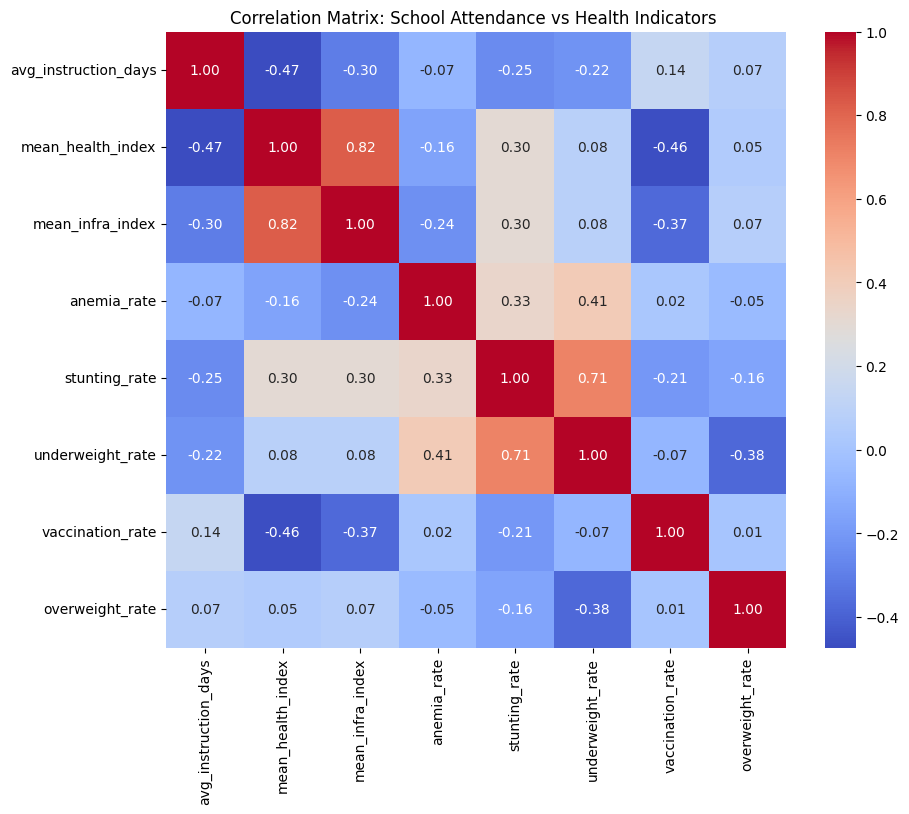

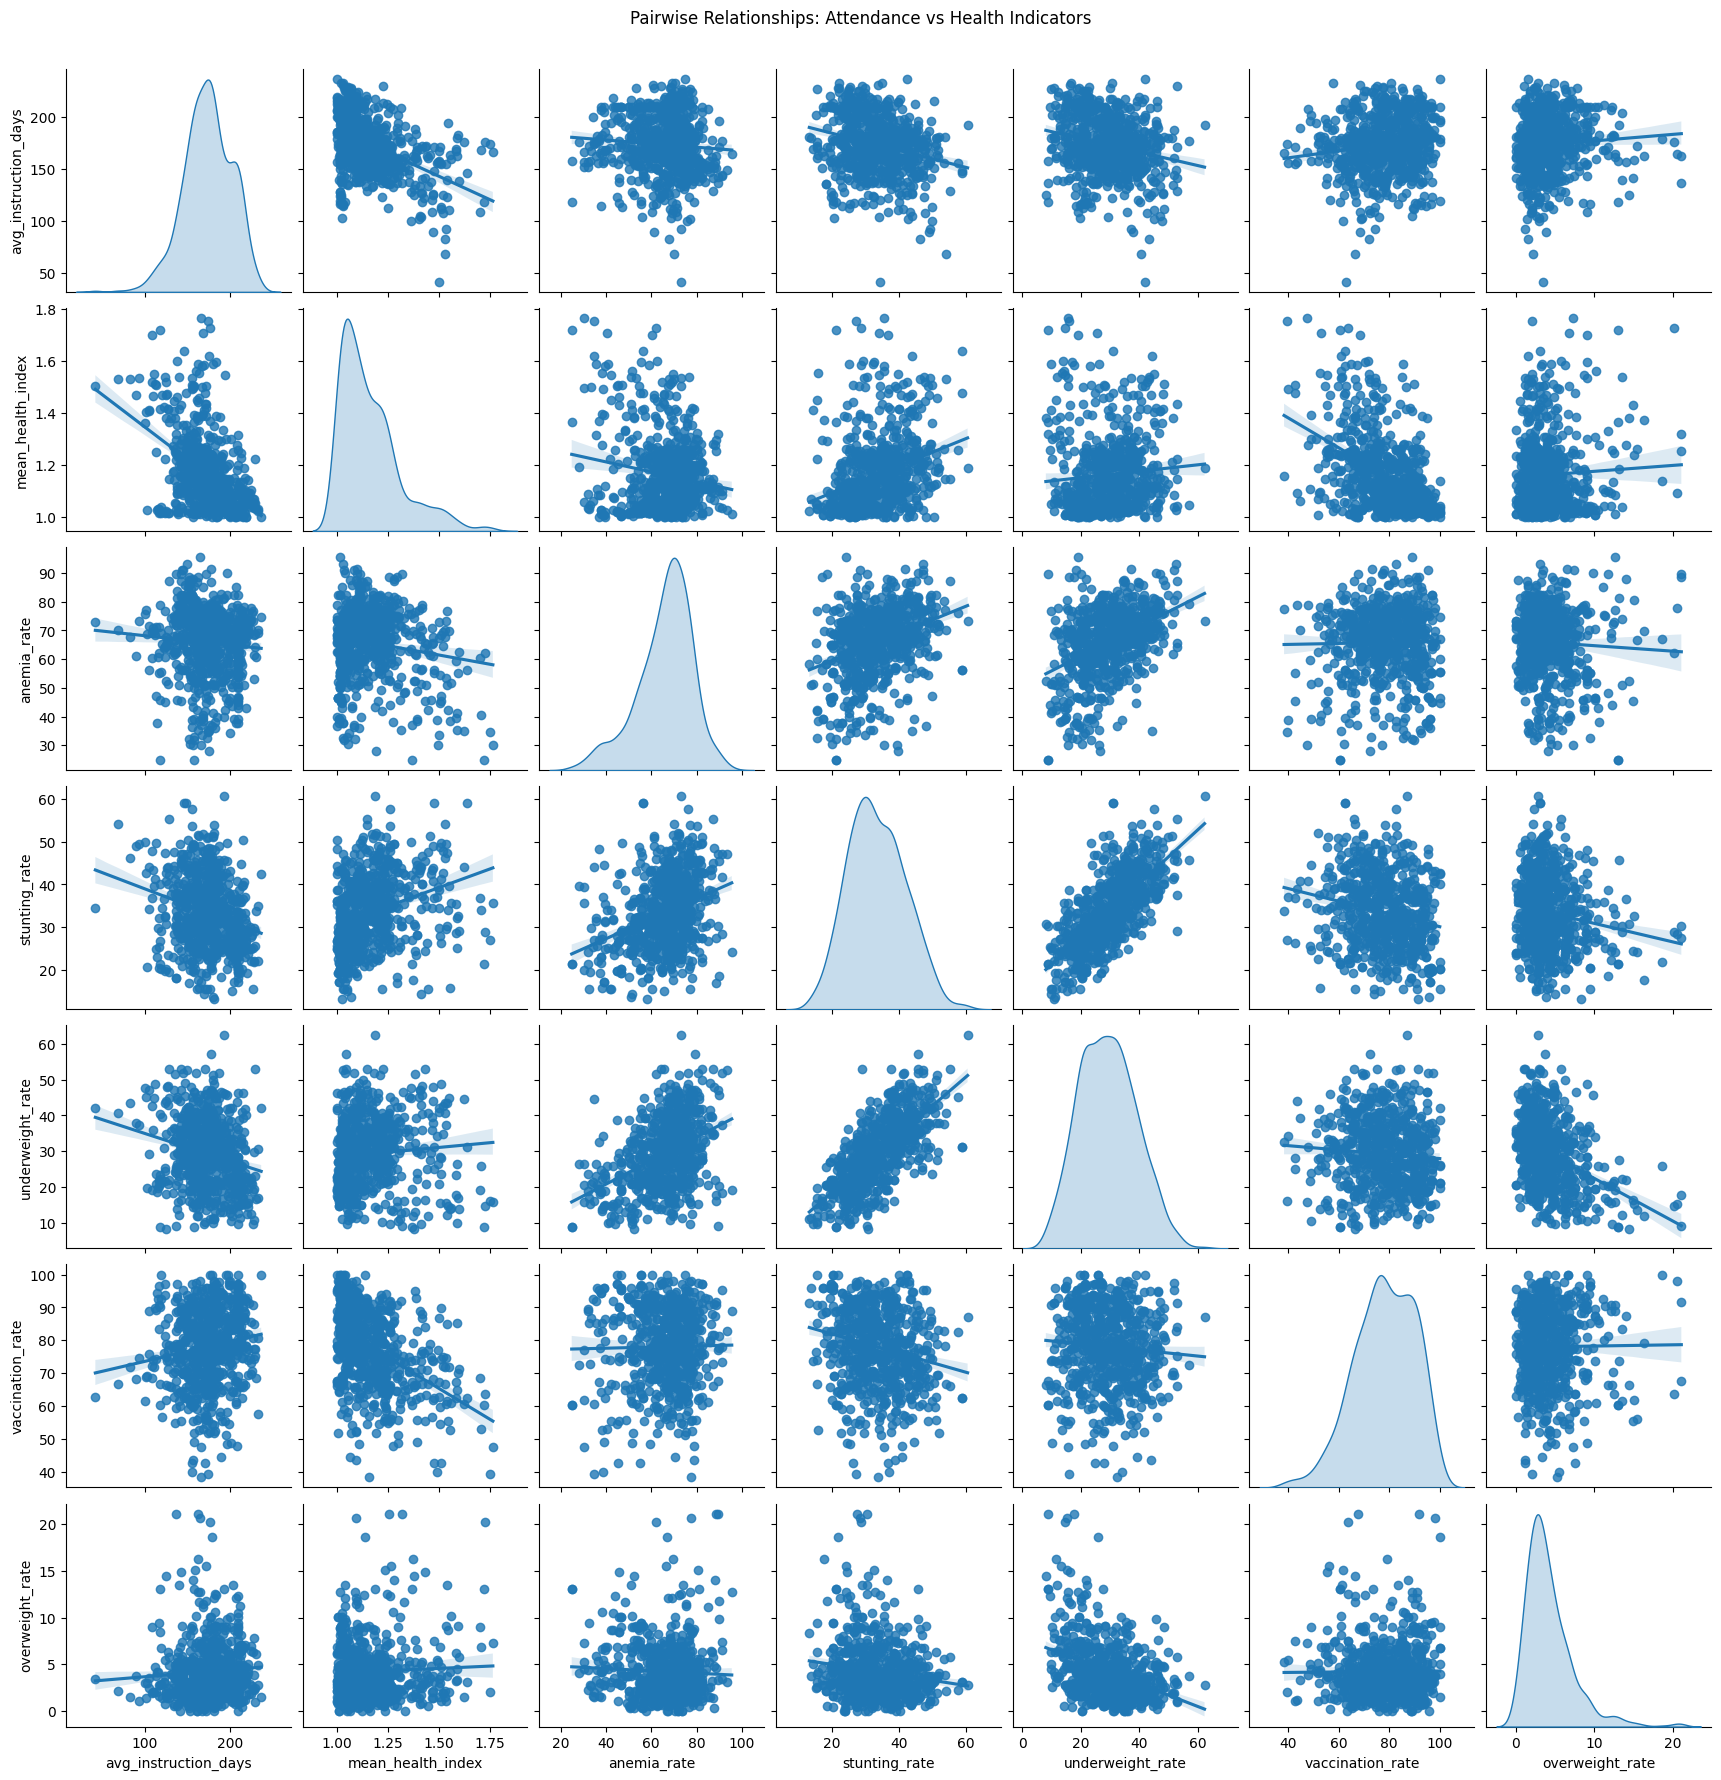

In [12]:
# ==========================================
# STEP 11: CORRELATION & VISUALIZATION
# ==========================================
plt.figure(figsize=(10,8))
sns.heatmap(analysis_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix: School Attendance vs Health Indicators ")
plt.show()

sns.pairplot(
    analysis_df,
    vars=['avg_instruction_days','mean_health_index', 'anemia_rate', 'stunting_rate', 'underweight_rate', 
          'vaccination_rate', 'overweight_rate'],
    kind='reg', diag_kind='kde'
)
plt.suptitle("Pairwise Relationships: Attendance vs Health Indicators", y=1.02)
plt.show()

✅ Regression Summary:


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     avg_instruction_days   R-squared:                       0.295
Model:                              OLS   Adj. R-squared:                  0.288
Method:                   Least Squares   F-statistic:                     41.46
Date:                  Sun, 09 Nov 2025   Prob (F-statistic):           7.71e-49
Time:                          21:36:32   Log-Likelihood:                -3205.9
No. Observations:                   700   AIC:                             6428.
Df Residuals:                       692   BIC:                             6464.
Df Model:                             7                                         
Covariance Type:              nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               334.1924     14.278     23.407      0.000     306.160     362.225
anemia_rate          -0.1474      0.088     -1.677      0.094      -0.320       0.025
stunting_rate         0.0798      0.165      0.483      0.629      -0.244       0.404
underweight_rate     -0.5161      0.151     -3.426      0.001      -0.812      -0.220
vaccination_rate     -0.2687      0.085     -3.150      0.002      -0.436      -0.101
overweight_rate       0.1848      0.324      0.570      0.569      -0.452       0.821
mean_health_index  -139.1624     11.230    -12.392      0.000    -161.212    -117.113
mean_infra_index     35.2510      8.411      4.191      0.000      18.737      51.765
==============================================================================
Omnibus:                       38.443   Durbin-Watson:                   0.856
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               47.854
Skew:                          -0.511   Prob(JB):                     4.06e-11
Kurtosis:                       3.771   Cond. No.                     2.00e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large,  2e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

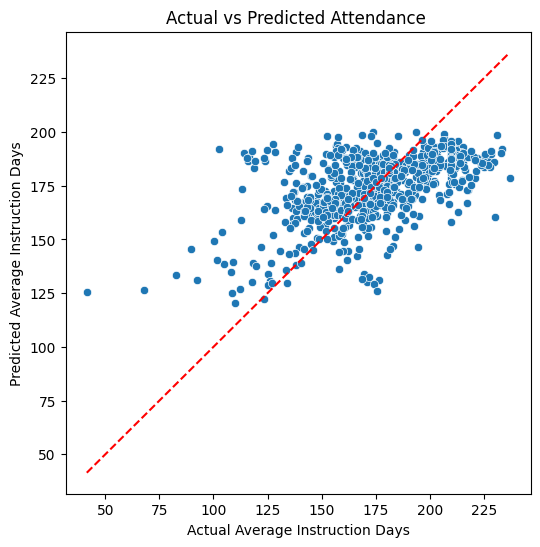

In [13]:
# ==========================================
# STEP 12: LINEAR REGRESSION ANALYSIS
# ==========================================


# Define predictors and target
X = analysis_df[['anemia_rate', 'stunting_rate', 'underweight_rate',
                 'vaccination_rate', 'overweight_rate', 
                 'mean_health_index', 'mean_infra_index']]
y = analysis_df['avg_instruction_days']

# Add constant term
X = sm.add_constant(X)

# Fit model
model = sm.OLS(y, X).fit()

print("✅ Regression Summary:")
display(model.summary())

# Plot predicted vs actual
analysis_df['predicted_attendance'] = model.predict(X)
plt.figure(figsize=(6,6))
sns.scatterplot(x='avg_instruction_days', y='predicted_attendance', data=analysis_df)
plt.plot([analysis_df['avg_instruction_days'].min(), analysis_df['avg_instruction_days'].max()],
         [analysis_df['avg_instruction_days'].min(), analysis_df['avg_instruction_days'].max()],
         color='red', linestyle='--')
plt.xlabel("Actual Average Instruction Days")
plt.ylabel("Predicted Average Instruction Days")
plt.title("Actual vs Predicted Attendance ")
plt.show()

✅ Random Forest R²: 0.044 | RMSE: 26.64


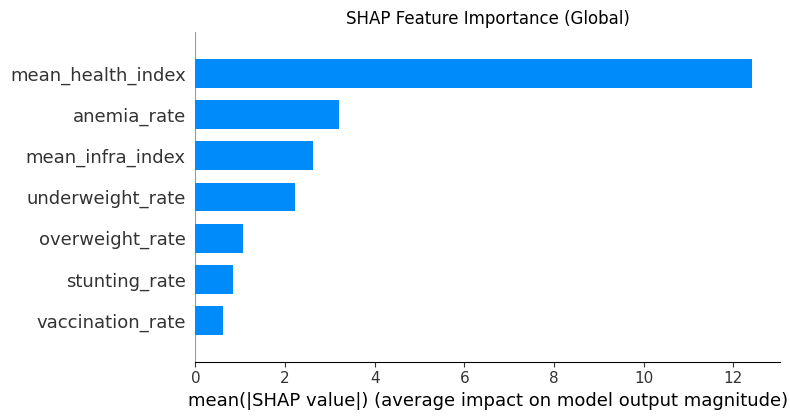

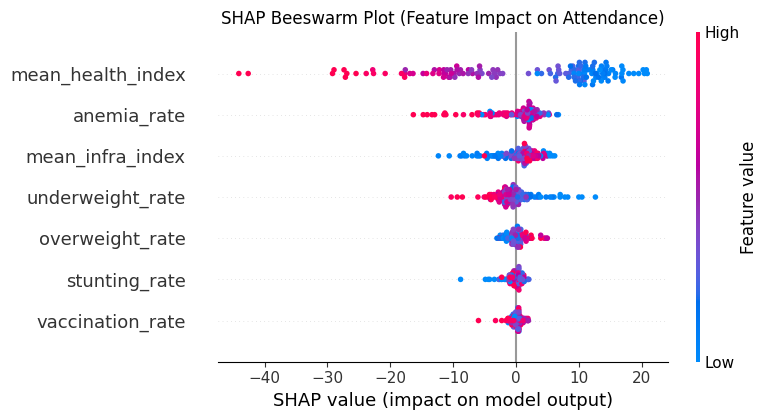

In [14]:
# ==========================================
# STEP 13: MODEL EXPLAINABILITY (SHAP ANALYSIS)
# ==========================================
import shap

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

X = analysis_df[['anemia_rate', 'stunting_rate', 'underweight_rate',
                 'vaccination_rate', 'overweight_rate',
                 'mean_health_index', 'mean_infra_index']]
y = analysis_df['avg_instruction_days']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ------------------------------------------
# Train Random Forest model (non-linear relationships)
# ------------------------------------------
rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=8,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

# ------------------------------------------
# Evaluate model
# ------------------------------------------
y_pred = rf.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred) ** 0.5  # Version-safe RMSE

print(f"✅ Random Forest R²: {r2:.3f} | RMSE: {rmse:.2f}")

# ------------------------------------------
# SHAP Explainability
# ------------------------------------------
shap.initjs()

# Some SHAP versions require shap.Explainer(model)(X)
# Using TreeExplainer for RandomForest
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)

# ------------------------------------------
# Global feature importance (bar plot)
# ------------------------------------------
plt.title("SHAP Feature Importance (Global)")
shap.summary_plot(shap_values, X_test, plot_type="bar", show=True)

# ------------------------------------------
# Detailed beeswarm plot
# ------------------------------------------
plt.title("SHAP Beeswarm Plot (Feature Impact on Attendance)")
shap.summary_plot(shap_values, X_test, show=True)

